In [28]:
import pandas as pd 
import numpy as np
import random
import os 
import re
import time
import math
import argparse
import pymysql
import json
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, BertTokenizer, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

In [9]:
# os.getcwd()

'F:\\NLP\\BERT\\Classification\\model1-2\\src'

In [14]:
origin_model = 'F:/NLP/BERT/models'

In [10]:
default_path = 'F:/NLP/BERT/Classification/model1-2'
data_path = os.path.join(default_path, 'data')
model_path = os.path.join(default_path, 'model')
config_path = os.path.join(default_path, 'config')
log_path = os.path.join(default_path, 'log')
config_file = "bert-base.json"

In [32]:
dsm_samp = pd.read_csv(os.path.join(data_path, 'dsm_samp2_test.csv'))
dsm_samp.head(3)

id                                               text  label
0     4fws4y  anyways, the doctor says be careful because yo...      3
1  t3_23p0b1  i also have [aka *amerge*] for migraines, but ...      3
2     26twx8  all in all i feel worthless pretty much the on...      8

In [33]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(origin_model, 'bert-base'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(origin_model, 'bert-base', 'bert_config.json'), output_hidden_states=True)
model = BertModel.from_pretrained(os.path.join(origin_model, 'bert-base'), config=config)

Some weights of the model checkpoint at F:/NLP/BERT/models\bert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
dsm_emb = []

for idx in range(len(dsm_samp)):
    encoded = tokenizer.encode_plus(
        text=dsm_samp.text[idx],  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 32,  # maximum length of a sentence
        pad_to_max_length=True,  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
    if idx % 1000 == 0:
        print(idx)
    # print(encoded)
    input_ids = torch.tensor(encoded['input_ids'])
    attn_mask = torch.tensor(encoded['attention_mask'])
    token_type_ids = torch.tensor(encoded['token_type_ids'])
    outputs = model(input_ids, attn_mask, token_type_ids)
    hidden_states = outputs[2]
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    dsm_emb.append(list(sentence_embedding.detach().cpu().numpy()))

0


<ipython-input-35-9ec594b5589e>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded['input_ids'])
<ipython-input-35-9ec594b5589e>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn_mask = torch.tensor(encoded['attention_mask'])
<ipython-input-35-9ec594b5589e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(encoded['token_type_ids'])


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


In [41]:
dsm_X = pd.DataFrame(dsm_emb, columns=range(len(dsm_emb[0])))
dsm_X

0         1         2         3         4         5         6    \
0      0.063190  0.498490  0.343533  0.011958 -0.032668 -0.411407  0.036385   
1      0.228747  0.214781  0.204014 -0.069902  0.242893  0.037496  0.042518   
2     -0.066509  0.004770  0.069475 -0.086337  0.151292 -0.282540 -0.145748   
3      0.261369  0.131222  0.167037  0.347231 -0.143047 -0.024225  0.039712   
4      0.213184  0.225374  0.268869 -0.189715 -0.170006 -0.229306 -0.162457   
...         ...       ...       ...       ...       ...       ...       ...   
19864 -0.169041  0.364298  0.366994  0.389625 -0.112893 -0.158083  0.042745   
19865 -0.059395  0.317109  0.180151 -0.008900 -0.142785 -0.137815 -0.200129   
19866 -0.366430  0.354413  0.119487 -0.051649 -0.187617 -0.220048 -0.154464   
19867 -0.468775  0.304044 -0.005343  0.212812 -0.207397 -0.243672 -0.332236   
19868  0.015493  0.116588  0.063643  0.056464 -0.317993  0.014876 -0.203223   

            7         8         9    ...       758       759       760  \
0      0.613341 -0.040944 -0.098675  ... -0.092053  0.037201  0.007882   
1      0.103701 -0.032079 -0.569990  ...  0.032456 -0.019728  0.314555   
2     -0.313602  0.160191  0.387372  ...  0.057735  0.026097  0.196059   
3     -0.262914 -0.094602  0.166473  ...  0.193645  0.137332  0.079967   
4      0.071092 -0.097309 -0.534082  ... -0.282927  0.382668  0.209568   
...         ...       ...       ...  ...       ...       ...       ...   
19864 -0.359096 -0.014162  0.093306  ...  0.278432  0.389329  0.031012   
19865  0.160382  0.193312  0.389540  ... -0.148501  0.188627  0.027152   
19866 -0.258841 -0.007702  0.336193  ... -0.261978  0.327497  0.426565   
19867  0.407520  0.272751  0.103619  ...  0.028842 -0.018940  0.353894   
19868  0.215388 -0.071865  0.333207  ...  0.104287 -0.275931  0.317184   

            761       762       763       764       765       766       767  
0      0.113183  0.099010 -0.236176 -0.002551  0.013318  0.009266 -0.069404  
1      0.078139  0.184804 -0.454248  0.134385  0.483311  0.025548 -0.095555  
2      0.007889  0.270071 -0.245282  0.393457  0.039988  0.086145  0.069251  
3     -0.038485  0.505542 -0.434010  0.282393 -0.262454 -0.218368  0.115366  
4      0.070450  0.137775 -0.206902  0.153168  0.173197  0.109622  0.096683  
...         ...       ...       ...       ...       ...       ...       ...  
19864 -0.092277  0.106793 -0.553634  0.010469 -0.254504  0.069898  0.156521  
19865 -0.113188 -0.403237 -0.346143  0.008146  0.050209  0.211157  0.066699  
19866  0.636790  0.059150 -0.527844 -0.019946 -0.172449  0.173072 -0.104583  
19867  0.070514  0.062635 -0.075510  0.401636 -0.120526  0.280045 -0.111361  
19868 -0.004512  0.344142 -0.294770  0.067042 -0.065109 -0.041387 -0.048187  

[19869 rows x 768 columns]

In [42]:
dsm_y = dsm_samp.label.tolist()

In [43]:
pca = PCA(n_components=2)
dsm_X = pca.fit_transform(dsm_X)

In [46]:
dsm_X[:, 0]

array([ 0.65664943, -3.33272295, -3.46448534, ..., -1.55104377,
        1.19061779, -1.30322711])

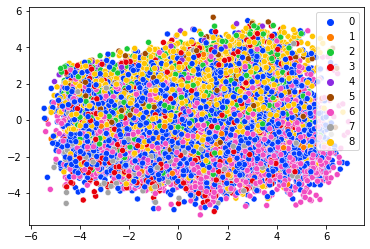

In [47]:
palette = sns.color_palette("bright", 9)
sns.scatterplot(x=dsm_X[:,0], y=dsm_X[:,1], hue=dsm_y, legend='full', palette=palette)
plt.show()

In [38]:
pca = PCA(n_components=30)
dsm_X = pca.fit_transform(dsm_X)

In [39]:
X_embedded = TSNE(n_components=2).fit_transform(dsm_X)

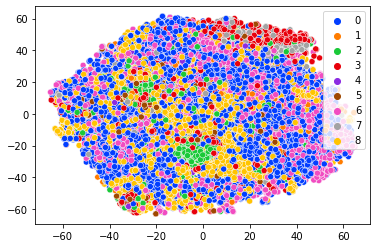

In [40]:
palette = sns.color_palette("bright", 9)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=dsm_y, legend='full', palette=palette)
plt.show()